# 基于PCA探索化学空间

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
 
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors,Crippen
 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
 
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

In [40]:
df = pd.read_csv('1ring_R2_gen_98w.smi', sep='\t', header=None, names=['SMILES', 'ID'])
data = df.iloc[:3000, :]
data.head()

,SMILES,ID
0,Nc1nc(N2CCC3(CC2)c2cnccc2C[C@H]3N)cnc1-c1cccc(...,1ring_r2_0
1,NC[C@@H]1C[C@@H](Cc2ccccc2)N(c2cnc(-c3cccc(Cl)...,1ring_r2_1
2,NCCNc1cnc(-c2cccc(Cl)c2Cl)c(N)n1,1ring_r2_2
3,CC(c1c(F)c(O)c[nH]c1=O)N1CCCC(Nc2cnc(-c3cccc(C...,1ring_r2_3
4,NC(=O)N1CC2Cc3ccn(c32)CC12CCN(c1cnc(-c3cccc(Cl...,1ring_r2_4


In [41]:
# calculate the descriptors and add them to dataframe
for i in data.index:
    mol=Chem.MolFromSmiles(data.loc[i,'SMILES'])
    if mol:
        data.loc[i,'MolWt']=Descriptors.ExactMolWt (mol)
        data.loc[i,'TPSA']=Chem.rdMolDescriptors.CalcTPSA(mol) #Topological Polar Surface Area
        data.loc[i,'nRotB']=Descriptors.NumRotatableBonds (mol) #Number of rotable bonds
        data.loc[i,'HBD']=Descriptors.NumHDonors(mol) #Number of H bond donors
        data.loc[i,'HBA']=Descriptors.NumHAcceptors(mol) #Number of H bond acceptors
        data.loc[i,'LogP']=Descriptors.MolLogP(mol) #LogP
data.head()

/home/xh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/xh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,SMILES,ID,MolWt,TPSA,nRotB,HBD,HBA,LogP
0,Nc1nc(N2CCC3(CC2)c2cnccc2C[C@H]3N)cnc1-c1cccc(...,1ring_r2_0,440.128300,93.95,2.0,2.0,6.0,3.8492
1,NC[C@@H]1C[C@@H](Cc2ccccc2)N(c2cnc(-c3cccc(Cl)...,1ring_r2_1,427.133051,81.06,5.0,2.0,5.0,4.4289
2,NCCNc1cnc(-c2cccc(Cl)c2Cl)c(N)n1,1ring_r2_2,297.054801,89.85,4.0,3.0,5.0,2.4032
3,CC(c1c(F)c(O)c[nH]c1=O)N1CCCC(Nc2cnc(-c3cccc(C...,1ring_r2_3,492.124358,120.16,5.0,4.0,7.0,4.2031
4,NC(=O)N1CC2Cc3ccn(c32)CC12CCN(c1cnc(-c3cccc(Cl...,1ring_r2_4,497.149764,106.30,2.0,2.0,6.0,3.9073


In [49]:
data.shape

(3000, 8)

In [51]:
descriptors = data.loc[:, ['MolWt', 'TPSA', 'nRotB', 'HBD','HBA', 'LogP']].values
descriptors_std = StandardScaler().fit_transform(descriptors)
descriptors_std[:5,:]

array([[ 0.71279765,  0.28359232, -0.94593203, -0.27757258,  0.41040212,
        -0.02451334],
       [ 0.45118499, -0.37174708,  1.4051832 , -0.27757258, -0.60377116,
         0.50221331],
       [-2.16747333,  0.07514457,  0.62147813,  0.95062469, -0.60377116,
        -1.33837696],
       [ 1.7595515 ,  1.61613271,  1.4051832 ,  2.17882196,  1.42457541,
         0.29704706],
       [ 1.86072   ,  0.91147762, -0.94593203, -0.27757258,  0.41040212,
         0.02827745]])

In [52]:
descriptors_std.shape

(3000, 6)

In [53]:
pca = PCA()
descriptors_2d = pca.fit_transform(descriptors_std)

In [54]:
descriptors_pca= pd.DataFrame(descriptors_2d)
descriptors_pca.index = data.index
descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]
descriptors_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,0.247915,-0.304772,-1.234791,-0.022467,0.150321,-0.164957
1,-0.565695,-0.978088,1.244523,0.176812,0.227345,-0.318831
2,0.355522,2.360364,1.541399,-0.051890,-0.107077,0.248033
3,3.132394,-1.853912,0.786824,-0.739697,-0.341532,-0.124882
4,0.799612,-1.153294,-1.587893,-0.241328,0.710719,-0.616364


In [48]:
descriptors_pca.shape

(100, 9)

In [44]:
print(pca.explained_variance_ratio_) 
print(sum(pca.explained_variance_ratio_))

[0.4664438  0.28390139 0.15114873 0.06624949 0.01673734 0.01551925]
0.9999999999999998


<Figure size 576x432 with 0 Axes>

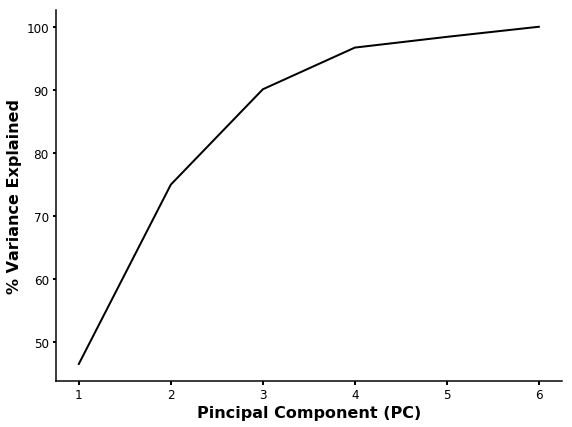

In [45]:
plt.rcParams['axes.linewidth'] = 1.5
plt.figure(figsize=(8,6))
fig, ax = plt.subplots(figsize=(8,6))
 
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
plt.plot([i+1 for i in range(len(var))],var,'k-',linewidth=2)
plt.xticks([i+1 for i in range(len(var))])
plt.ylabel('% Variance Explained',fontsize=16,fontweight='bold')
plt.xlabel('Pincipal Component (PC)',fontsize=16,fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.tick_params ('both',width=2,labelsize=12)

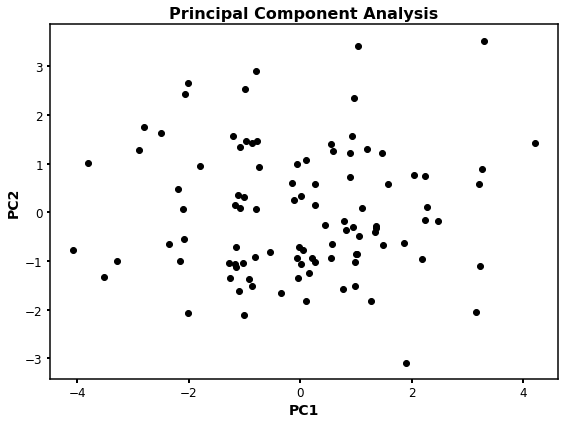

In [46]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
 
ax.plot(descriptors_pca['PC1'],descriptors_pca['PC2'],'o',color='k')
ax.set_title ('Principal Component Analysis',fontsize=16,fontweight='bold',family='sans-serif')
ax.set_xlabel ('PC1',fontsize=14,fontweight='bold')
ax.set_ylabel ('PC2',fontsize=14,fontweight='bold')
 
plt.tick_params ('both',width=2,labelsize=12)
 
plt.tight_layout()
plt.show()

In [34]:
# 将PCA值从-1重新缩放到1，因为想要在特征（描述符）的协方差周期内分析数据
# This normalization will be performed just for PC1 and PC2, but can be done for all the components.
scale1 = 1.0/(max(descriptors_pca['PC1']) - min(descriptors_pca['PC1']))
scale2 = 1.0/(max(descriptors_pca['PC2']) - min(descriptors_pca['PC2']))
 
# add the new values to our PCA coloum
descriptors_pca['PC1_normalized']=[i*scale1 for i in descriptors_pca['PC1']]
descriptors_pca['PC2_normalized']=[i*scale2 for i in descriptors_pca['PC2']]

descriptors_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC1_normalized,PC2_normalized
0,-0.116278,0.251917,-1.156125,-0.075335,-0.129677,-0.110983,-0.014026,0.038068
1,0.891721,1.210109,0.674252,0.158433,-0.237181,-0.293948,0.107563,0.182863
2,0.112615,-1.818270,1.714852,0.122210,0.240820,-0.006308,0.013584,-0.274764
3,-2.807986,1.762932,0.689980,-0.841039,-0.111579,0.213289,-0.338711,0.266401
4,-0.733963,0.937433,-1.578741,-0.304968,-0.420519,-0.706402,-0.088534,0.141658


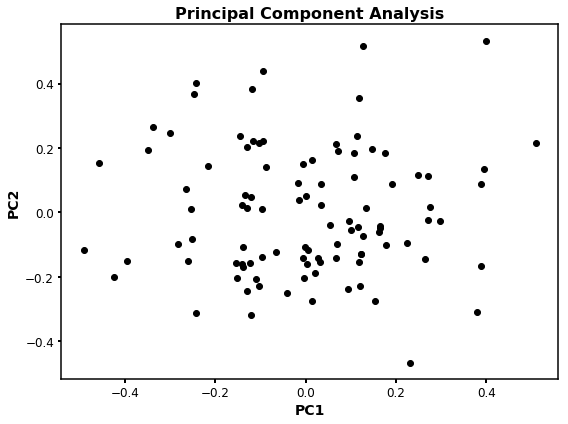

In [35]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
 
ax.plot(descriptors_pca['PC1_normalized'],descriptors_pca['PC2_normalized'],'o',color='k')
ax.set_title ('Principal Component Analysis',fontsize=16,fontweight='bold',family='sans-serif')
ax.set_xlabel ('PC1',fontsize=14,fontweight='bold')
ax.set_ylabel ('PC2',fontsize=14,fontweight='bold')
 
plt.tick_params ('both',width=2,labelsize=12)
 
plt.tight_layout()
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.3396502597912097
For n_clusters = 3 The average silhouette_score is : 0.34805286522370626
For n_clusters = 4 The average silhouette_score is : 0.3658007453255997
For n_clusters = 5 The average silhouette_score is : 0.35032227389901416
For n_clusters = 6 The average silhouette_score is : 0.3383082626059666
For n_clusters = 7 The average silhouette_score is : 0.34343411732045787
For n_clusters = 8 The average silhouette_score is : 0.36551419954215747
For n_clusters = 9 The average silhouette_score is : 0.3634274068264361
For n_clusters = 10 The average silhouette_score is : 0.39411258724930676


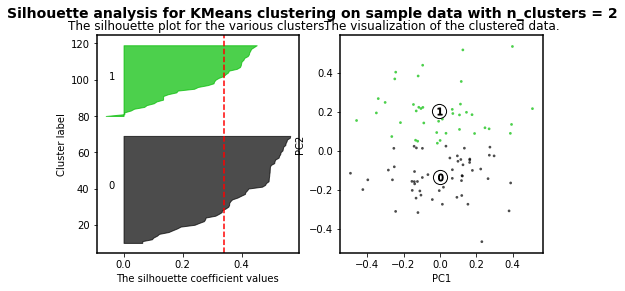

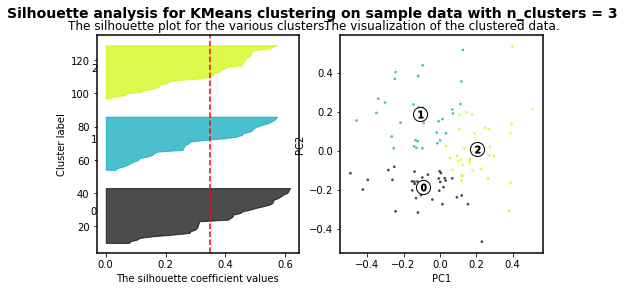

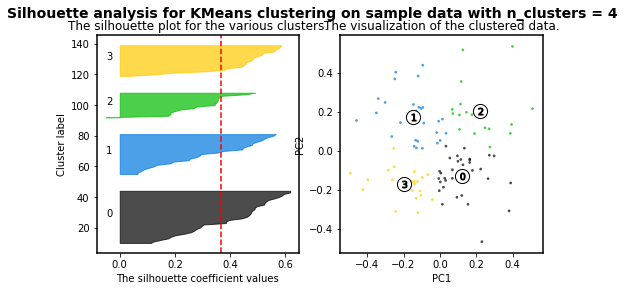

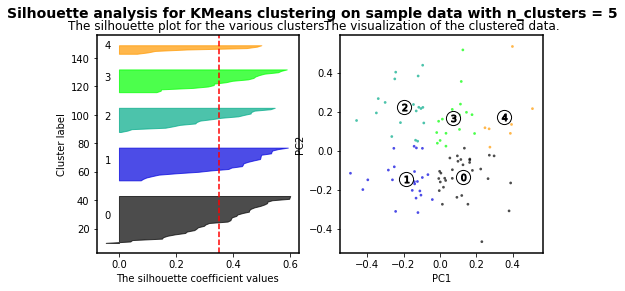

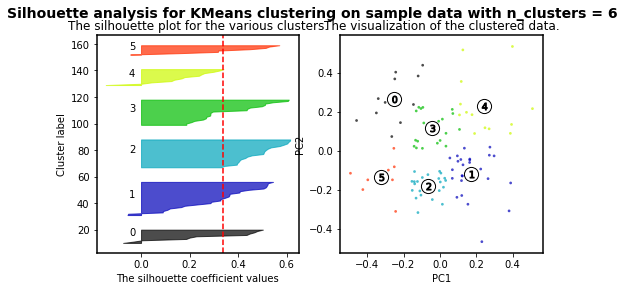

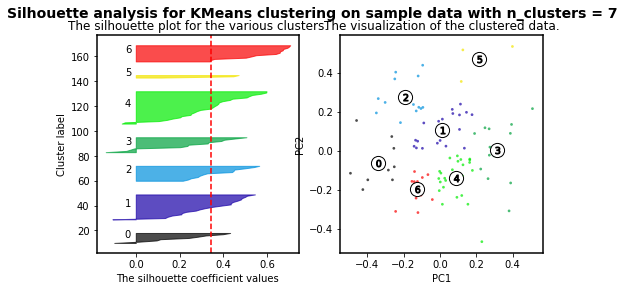

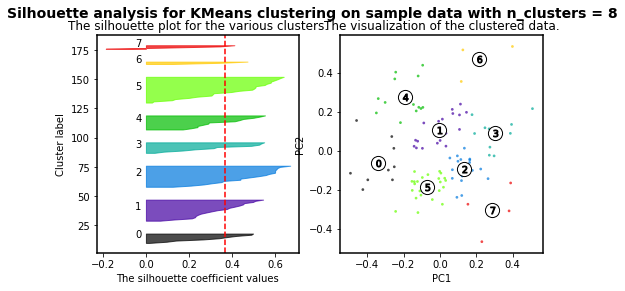

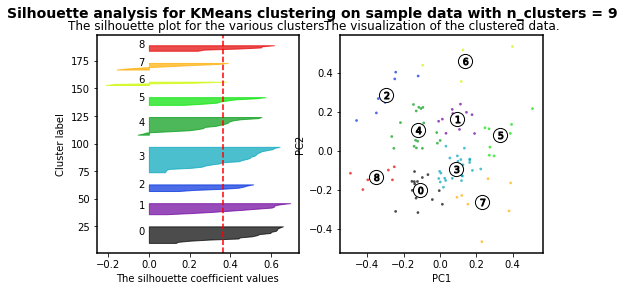

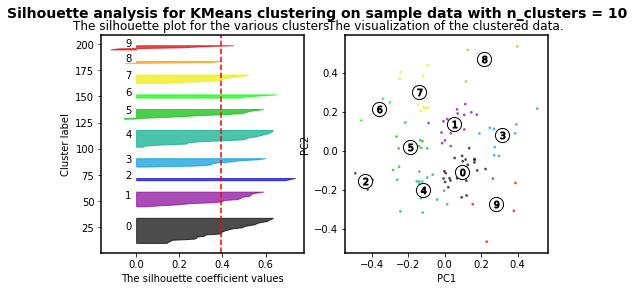

In [36]:
range_n_clusters = [2, 3, 4, 5, 6, 7,8,9,10]
for n_clusters in range_n_clusters:
    fig, (ax1,ax2)= plt.subplots(1, 2)
    fig.set_size_inches(8, 4)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = kmeans.fit_predict(descriptors_pca[['PC1_normalized','PC2_normalized']])
    silhouette_avg = silhouette_score(descriptors_pca[['PC1_normalized','PC2_normalized']], cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(descriptors_pca[['PC1_normalized','PC2_normalized']], cluster_labels)
 
    y_lower = 10
    
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
 
        ith_cluster_silhouette_values.sort()
 
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
 
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
 
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
 
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
 
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
 
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
 
 
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(descriptors_pca['PC1_normalized'], descriptors_pca['PC2_normalized'], 
                marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')
 
 
    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
 
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
 
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")
 
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
     
plt.show()
# Silhouette_score越高，群集分布越好。

In [37]:
kmeans = KMeans(n_clusters=2, random_state=10) # We define the best number of clusters
clusters = kmeans.fit(descriptors_pca[['PC1_normalized','PC2_normalized']]) #PC1 vs PC2 (normalized values)

descriptors_pca['Cluster_PC1_PC2'] = pd.Series(clusters.labels_, index=data.index)
descriptors_pca.head(10)


,PC1,PC2,PC3,PC4,PC5,PC6,PC1_normalized,PC2_normalized,Cluster_PC1_PC2
0,-0.116278,0.251917,-1.156125,-0.075335,-0.129677,-0.110983,-0.014026,0.038068,1
1,0.891721,1.210109,0.674252,0.158433,-0.237181,-0.293948,0.107563,0.182863,1
2,0.112615,-1.818270,1.714852,0.122210,0.240820,-0.006308,0.013584,-0.274764,0
3,-2.807986,1.762932,0.689980,-0.841039,-0.111579,0.213289,-0.338711,0.266401,1
4,-0.733963,0.937433,-1.578741,-0.304968,-0.420519,-0.706402,-0.088534,0.141658,1
5,-1.000617,-2.100228,0.187115,0.076118,0.028095,0.059568,-0.120699,-0.317371,0
6,1.209801,1.298708,1.499537,-1.424969,-0.085470,-0.047168,0.145931,0.196251,1
7,1.021706,-0.861612,0.285650,0.214413,0.119010,-0.098256,0.123242,-0.130200,0
8,-4.074508,-0.767068,0.190074,-0.377907,1.498854,-0.022069,-0.491484,-0.115914,0
9,-2.016910,-2.060406,1.866921,-0.153405,0.387937,-0.030336,-0.243288,-0.311353,0


#### 绘制PC1与PC2数据， 每个群集将具有不同的颜色，将找到每个主要组件的主要特征。

<Figure size 720x576 with 0 Axes>

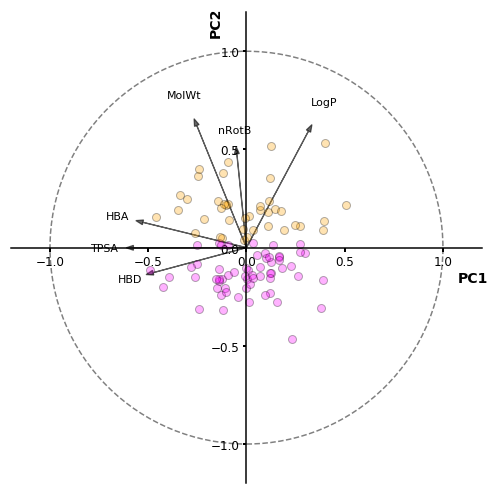

In [38]:
plt.rcParams['axes.linewidth'] = 1.5
plt.figure(figsize=(10,8))
 
fig, ax = plt.subplots(figsize=(7,7))
 
color_code={ 0:        'magenta',\
             1.0:   'orange',\
             2.0:      'cyan',\
             3.0:           'c',\
             4.0:        'm',\
             5.0:        'y',\
             6.0:        'darkorange',
             7.0:       'k',
             }
 
for i in descriptors_pca.index: 
        ax.plot(descriptors_pca.loc[i].at['PC1_normalized'],descriptors_pca.loc[i].at['PC2_normalized'],
                    c=color_code[descriptors_pca.loc[i].at['Cluster_PC1_PC2']],
                    marker='o',markersize=8,markeredgecolor='k',alpha=0.3)
        
 
plt.xlabel ('PC1',fontsize=14,fontweight='bold')
ax.xaxis.set_label_coords(0.98, 0.45)
plt.ylabel ('PC2',fontsize=14,fontweight='bold')
ax.yaxis.set_label_coords(0.45, 0.98)
plt.tick_params ('both',width=2,labelsize=12)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
 
lab=['MolWt', 'TPSA', 'nRotB', 'HBD','HBA', 'LogP'] #Feature labels
 
l=np.transpose(pca.components_[0:2, :]) ## We will get the components eigenvectors (main features) for PC1 and PC2
 
n = l.shape[0]
for i in range(n):
    plt.arrow(0, 0, l[i,0], l[i,1],color= 'k',alpha=0.6,linewidth=1.2,head_width=0.025)
    plt.text(l[i,0]*1.25, l[i,1]*1.25, lab[i], color = 'k',va = 'center', ha = 'center',fontsize=11)
 
circle = plt.Circle((0,0), 1, color='gray', fill=False,clip_on=True,linewidth=1.5,linestyle='--')
ax.add_artist(circle)
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.tight_layout()
plt.savefig("fig1.png", dpi=300)
plt.show()


In [39]:
data = data.join(descriptors_pca)
data.head()

,SMILES,ID,MolWt,TPSA,nRotB,HBD,HBA,LogP,PC1,PC2,PC3,PC4,PC5,PC6,PC1_normalized,PC2_normalized,Cluster_PC1_PC2
0,Nc1nc(N2CCC3(CC2)c2cnccc2C[C@H]3N)cnc1-c1cccc(...,1ring_r2_0,440.128300,93.95,2.0,2.0,6.0,3.8492,-0.116278,0.251917,-1.156125,-0.075335,-0.129677,-0.110983,-0.014026,0.038068,1
1,NC[C@@H]1C[C@@H](Cc2ccccc2)N(c2cnc(-c3cccc(Cl)...,1ring_r2_1,427.133051,81.06,5.0,2.0,5.0,4.4289,0.891721,1.210109,0.674252,0.158433,-0.237181,-0.293948,0.107563,0.182863,1
2,NCCNc1cnc(-c2cccc(Cl)c2Cl)c(N)n1,1ring_r2_2,297.054801,89.85,4.0,3.0,5.0,2.4032,0.112615,-1.818270,1.714852,0.122210,0.240820,-0.006308,0.013584,-0.274764,0
3,CC(c1c(F)c(O)c[nH]c1=O)N1CCCC(Nc2cnc(-c3cccc(C...,1ring_r2_3,492.124358,120.16,5.0,4.0,7.0,4.2031,-2.807986,1.762932,0.689980,-0.841039,-0.111579,0.213289,-0.338711,0.266401,1
4,NC(=O)N1CC2Cc3ccn(c32)CC12CCN(c1cnc(-c3cccc(Cl...,1ring_r2_4,497.149764,106.30,2.0,2.0,6.0,3.9073,-0.733963,0.937433,-1.578741,-0.304968,-0.420519,-0.706402,-0.088534,0.141658,1
